<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-hyeondata/blob/main/Chapter2_1_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT로 뉴스 기사 분류 모델 학습하기

이번 과제에서는 pre-trained 된 GPT를 가지고 뉴스 기사 분류 모델을 구현합니다. GPT와 BERT의 차이점에 유의하여 과제를 수행하시면 됩니다.

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00


# Tokenizer 및 `TextClassifier`의 encoder를 GPT로 변경
    - `distilbert-base-uncased`로 설정한 tokenizer와 encoder를 `openai-gpt`로 변경해줍니다.
    - GPT의 tokenizer는 padding token이 없어, 다음 코드로 padding token을 추가해줍니다:

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'openai-gpt') #openai-gpt로 변경
tokenizer.pad_token = tokenizer.unk_token #padding token 추가

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://h

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
tokenizer

OpenAIGPTTokenizerFast(name_or_path='openai-gpt', vocab_size=40478, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [13]:
print(max(ds["test"]['label']))
print(min(ds["test"]['label']))

3
0


In [6]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

OpenAIGPTModel(
  (tokens_embed): Embedding(40478, 768)
  (positions_embed): Embedding(512, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x Block(
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)

# Classify 할 때 사용하는 token representation 변경
    - 현재 `TextClassifier`는 첫 번째 token의 representation으로 label을 예측하고 있습니다.
    - 하지만 GPT의 pre-train 방식을 생각하면 첫 번째 token으로 label을 예측하면 안됩니다.
    - GPT의 pre-train 방식과 이전 RNN 실습에서 아이디어를 얻어 classify를 할 때 사용하는 token representation을 적절하게 변경하시면 됩니다.

In [7]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
    self.classifier = nn.Linear(768, 4)


  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']

    x = self.classifier(x[:, -1]) #변경
    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)
      # preds = (preds > 0).long()[..., 0]

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()
  # print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

  return acc / cnt





In [10]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

train_acc_list = []
test_acc_list = []

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()


optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc_list.append(accuracy(model, train_loader))
  test_acc_list.append(accuracy(model, test_loader))


  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

Epoch   0 | Train Loss: 1319.4269857108593
Epoch   1 | Train Loss: 1105.7951119542122
Epoch   2 | Train Loss: 1087.3474676311016
Epoch   3 | Train Loss: 1076.2783177793026
Epoch   4 | Train Loss: 1073.55755071342
Epoch   5 | Train Loss: 1060.3481550365686
Epoch   6 | Train Loss: 1063.76057985425
Epoch   7 | Train Loss: 1063.13127489388
Epoch   8 | Train Loss: 1060.0015384405851
Epoch   9 | Train Loss: 1057.365991935134


# 학습 결과 Report

### epoch 마다 train, test의 정확도를 보여주는 plot 입니다.

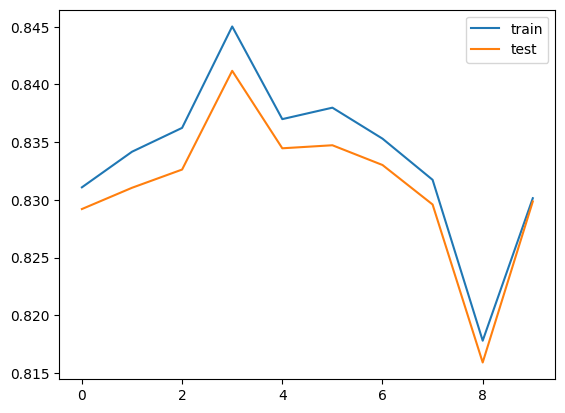

In [11]:
import matplotlib.pyplot as plt

def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(train_acc_list, test_acc_list)

위의 plot을 보면 train과 test가 정확도가 비슷하게 가고 있는 것을 알 수 있다.

## 최종 모델의 train과 test의 정확도 입니다.

In [12]:
with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.830 | Test acc: 0.830
